## Load Packages

In [1]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  TransformedTargetRegressor

from env import *
from plotting.plot import *
from processing.data import Data

pd.pandas.set_option('display.max_columns', None)

# Import Data

In [2]:

train = Data.from_csv(filepath=DIR_DATA_TRAIN, index_col=COL_ID)
test  = Data.from_csv(filepath=DIR_DATA_TEST, index_col=COL_ID)
print(train)
repr(train)

Table metadata updated
Table metadata updated
A dataframe with 1460 rows and 80 columns


'Data(df)'

In [3]:
# Create more human-readable columns
for regex, repl in REGEX_REPL_COLUMN:
    train.columns = train.columns.map(lambda x: re.sub(string=x, pattern=regex, repl=repl))
    test.columns = test.columns.map(lambda x: re.sub(string=x, pattern=regex, repl=repl))

train.columns = train.columns.map(str.lower)
test.columns  = test.columns.map(str.lower)

train.col_target = COL_TARGET
test.col_target = COL_TARGET

print(f'Columns of training data: {train.columns.tolist()}')

Set 'sale_price' as target feature
Set 'sale_price' as target feature
Columns of training data: ['ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'overall_quality', 'overall_condition', 'year_built', 'year_remod_add', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'masonry_veneer_area', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_sq_ft_1', 'basement_finished_type_2', 'basement_finished_sq_ft_2', 'basement_unf_sq_ft', 'total_basement_sq_ft', 'heating', 'heating_quality_condition', 'central_air', 'electrical', '1st_floor_sq_ft', '2nd_floor_sq_ft', 'low_quality_finished_sq_ft', 'ground_liv_area', 'basement_full_bath', 'basement_half_bath', 'full_bath', 'half_ba

***
# Exploratory Data Analysis

## Variable Types

In [4]:
train.print_column_types()

There are 43 categorical fields:
['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_type_2', 'heating', 'heating_quality_condition', 'central_air', 'electrical', 'kitchen_quality', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_quality', 'garage_condition', 'paved_drive', 'pool_quality_condition', 'fence', 'misc_feature', 'sale_type', 'sale_condition']
There are 37 numerical fields:
['ms_sub_class', 'lot_frontage', 'lot_area', 'overall_quality', 'overall_condition', 'year_built', 'year_remod_add', 'masonry_veneer_area', 'basement_finished_sq_ft_1', 'basement_finished_sq_ft_2', 'basement_unf

In [5]:
train.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ms_sub_class                1460 non-null   int64  
 1   ms_zoning                   1460 non-null   object 
 2   lot_frontage                1201 non-null   float64
 3   lot_area                    1460 non-null   int64  
 4   street                      1460 non-null   object 
 5   alley                       91 non-null     object 
 6   lot_shape                   1460 non-null   object 
 7   land_contour                1460 non-null   object 
 8   utilities                   1460 non-null   object 
 9   lot_config                  1460 non-null   object 
 10  land_slope                  1460 non-null   object 
 11  neighborhood                1460 non-null   object 
 12  condition_1                 1460 non-null   object 
 13  condition_2                 1460 

***
# Process Data

## Remove Uninformative Features

In [6]:
train.drop_columns_regex(regex='^misc')


Removed columns:
['misc_feature', 'misc_value']
Table metadata updated


## Unique Values

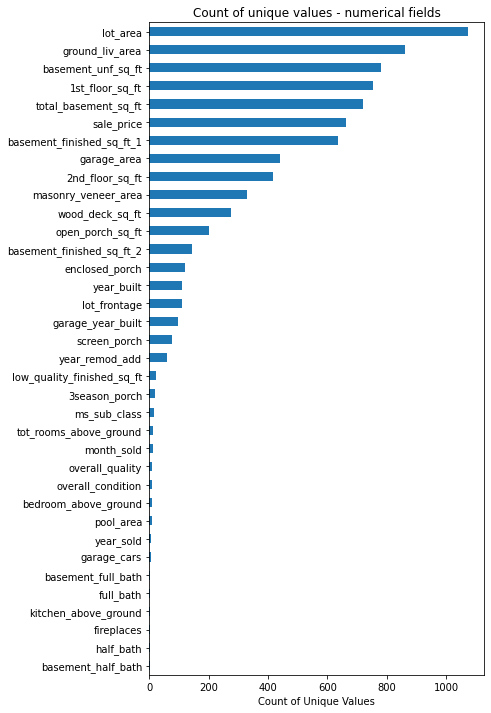

In [7]:
plot_count_unique(train.df, 
                  dtype_include=['float64', 'int64'],
                  title='Count of unique values - numerical fields')

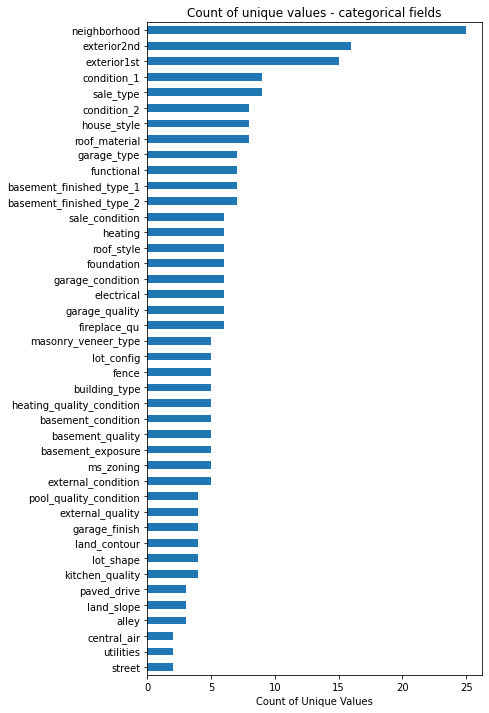

In [8]:
plot_count_unique(train.df, 
                  dtype_include=['O'],
                  title='Count of unique values - categorical fields')

In [9]:
train.remove_constant_columns()

Table metadata updated
Found 0 constant column(s).
Removed columns:
[]


### Aggregate low count categorical features to 'other' category

In [10]:
cat_count_unique = train.count_unique(dtypes='object')

CATEGORICAL_COL_COUNT_THRESHOLD = 10
CATEGORICAL_GROUPING_THRESHOLD = 0.01

for col in cat_count_unique.index[cat_count_unique > CATEGORICAL_COL_COUNT_THRESHOLD]:

    # Apply grouping of categories to training set
    cat_group_mapping = train.group_low_count_categories(col=col, fill_value='Other', threshold=CATEGORICAL_GROUPING_THRESHOLD)
    
    # Apply grouping of categories to test set
    test.df[col] = test.df[col].replace(cat_group_mapping)

## Missing Values

In [11]:
col_missing_bool = train.df.apply(lambda x: x.isnull().sum() > 0)
col_missing_desc = train.df.columns[col_missing_bool].tolist()

print(f'Columns with missing values:')
print("\n".join(col_missing_desc))

Columns with missing values:
lot_frontage
alley
masonry_veneer_type
masonry_veneer_area
basement_quality
basement_condition
basement_exposure
basement_finished_type_1
basement_finished_type_2
electrical
fireplace_qu
garage_type
garage_year_built
garage_finish
garage_quality
garage_condition
pool_quality_condition
fence


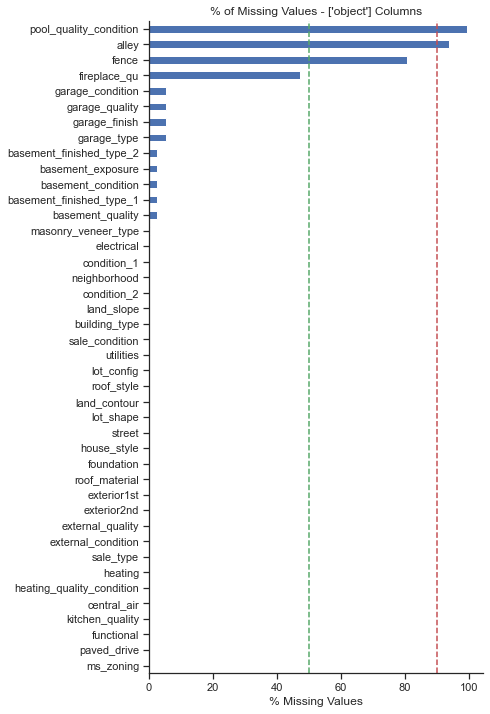

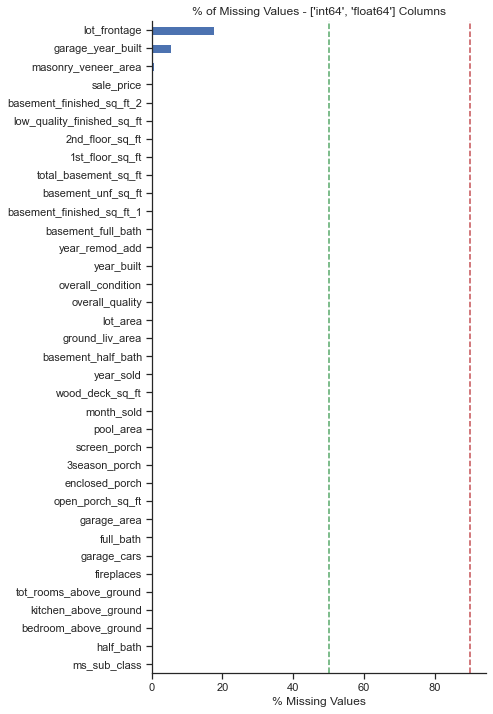

In [12]:
sns.set_theme(
    style="ticks", 
    # palette=sns.color_palette("Set1"), 
    rc=custom_params)

# Plot percentage of missing data
for dtypes in [['object',], ['int64', 'float64']]:

    plot_perc_missing(
        train.df, 
        title=f'% of Missing Values - {dtypes} Columns',
        dtype_include=dtypes,
        )

### Remove columns with many missing values

In [13]:
train.remove_missing_columns(threshold=MISSING_THRESHOLD_DROP)

Found 3 column(s) with missing values above the 0.5 threshold.
Removed columns:
['alley', 'pool_quality_condition', 'fence']
Table metadata updated


### Create flag for missing values

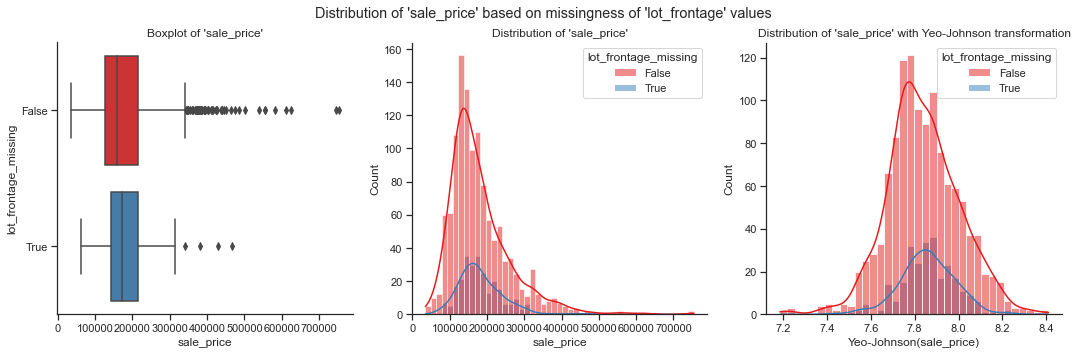

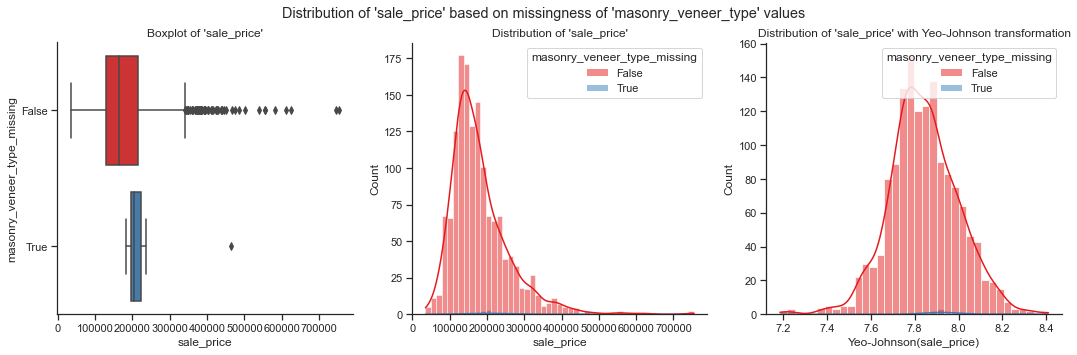

In [14]:
col_missing_bool = train.df.apply(lambda x: x.isnull().sum() > 0)
col_missing_desc = train.df.columns[col_missing_bool].tolist()

for col in col_missing_desc:

    boxplot_histogram_missingness_relationship(
        df=train.df, 
        col_var=col, 
        col_target=train.col_target, 
        add_kde=True,
        add_yeojohnson=True)

In [ ]:
train.add_flag_missing_values(
    ttest_threshold=FLAG_MISSING_PVALUE_TRESHOLD,
    ttest_min_samples=FLAG_MISSING_MIN_SAMPLES, 
    yeojohnson_transform=True
    )


## Datetime Features

### Create features from time data

In [ ]:
train.create_column(
    col_name='year_built_or_remod', 
    values=train.df[['year_remod_add', 'year_built']].apply(np.max, axis=1))

def x(a,b):
    return np.max([a-b, 0])

# Calculate age when sold
train.create_column(
    col_name='age_garage_when_sold',
    values=train.df.apply(lambda f: x(f['year_sold'], f['garage_year_built']), axis=1))

train.create_column(
    col_name='age_house_when_sold', 
    values=train.df.apply(lambda f: x(f['year_sold'], f['year_built_or_remod']), axis=1))

train.drop_columns_regex(regex='year(?!.+missing$)')

## Discrete Features

In [ ]:
# ms_sub_class is a categorical feature
train.change_column_types({'ms_sub_class': 'object'})

In [ ]:
train.print_column_types()

In [ ]:
discrete_cols   = [col for col in train.num_columns if len(train.df[col].unique()) < 20]
continuous_cols = [col for col in train.num_columns if col not in discrete_cols]

train.df[discrete_cols].head(10)

### Relationship with Target Feature

In [ ]:
for col in discrete_cols:
    
    sns.set_theme(
            style="ticks", 
            palette=sns.color_palette("Reds"), 
            rc=custom_params)
    
    sns.catplot(data=train.df, x=col, y=COL_TARGET, kind='box', height=4.5, aspect=1.7)
    sns.stripplot(data=train.df, x=col, y=COL_TARGET, jitter=0.1, alpha=0.1, color='k')
    plt.title(f'Distribution of \'{COL_TARGET}\' by \'{col}\'')
    plt.ylabel(COL_TARGET.replace('_', ' ').upper())
    plt.xlabel(col.replace('_', ' ').upper())
    plt.show()

## Numerical features

In [ ]:
train.df[continuous_cols].head()

In [ ]:
sns.set_theme(
            style="white", 
            palette=sns.color_palette("Set2"), 
            rc={
                "axes.grid": False, 
                "grid.color": '0.95', 
                "axes.spines.right": False, 
                "axes.spines.top": False
                })

train.df.loc[:, continuous_cols].hist(bins=15, figsize=(15,15))
plt.suptitle(f'Distribution of Values for Numerical Features')
plt.show()

### Analyse Feature Correlation

In [ ]:
plot_correlation_heatmap(train.df)

### Remove Features with low correlation to target

In [ ]:
plot_feature_correlations(train.df, col_target=train.col_target, threshold=CORRELATION_TARGET_THRESHOLD)

In [ ]:
train.remove_correlation_features(threshold=CORRELATION_TARGET_THRESHOLD)

### Process numerical features with high collinearity

In [ ]:
train.remove_highly_collinear_features(threshold=COLLINEARITY_THRESHOLD)

### Process highly correlated categorical features

In [ ]:
CRAMER_MAX_CARDINALITY = 4
CATEGORICAL_CORRELATION_THRESHOLD = 0.80
CATEGORICAL_CORRELATION_SELECTION_STRATEGY = 'cardinality' # 'cardinality' 

feats = train.remove_highly_correlated_categorical_features(
    cramer_max_cardinality=CRAMER_MAX_CARDINALITY,
    cramer_threshold=CATEGORICAL_CORRELATION_THRESHOLD,
    selection_strategy=CATEGORICAL_CORRELATION_SELECTION_STRATEGY
)

### Remove categorical features with low correlation to target

In [ ]:
for col in train.cat_columns:

    sns.histplot(
        x=train.df[train.col_target],
        hue=train.df[col]
    )
    plt.show()

In [ ]:
CATEGORICAL_SIGNIFICANCE_PVALUE=0.05
CATEGORICAL_SIGNIFICANCE_YEOJOHNSON=True

train.remove_categorical_significance_test(
    p_value_threshold=CATEGORICAL_SIGNIFICANCE_PVALUE,
    yeojohnson_transform=CATEGORICAL_SIGNIFICANCE_YEOJOHNSON
)